Yo encontre este dataset con diversos datos de clientes de un centro comercial. El dataset se encuentra aquí: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

In [156]:
#Importando librerias y el dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Mall_Customers.csv')
df.head()

#La variable spending score contiene un puntaje calculado por el centro comercial que se basa en cuanto gastan los clientes en el centro comercial y qué tan frecuentemente lo hacen.

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [157]:
#Elimino la columna CustomerID ya que solo tiene el indice y no nos es util.
df.drop('CustomerID', axis=1, inplace=True)

df.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [158]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB
None


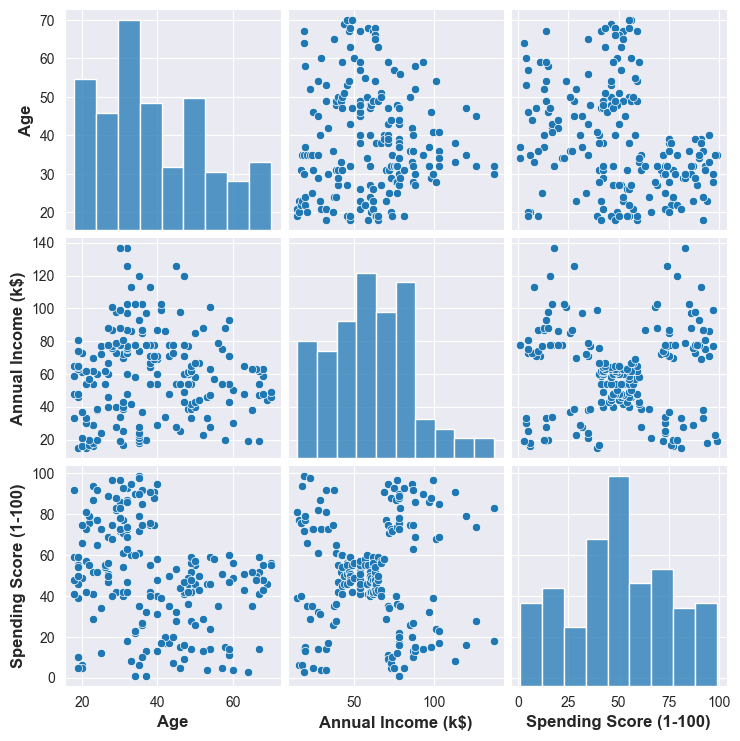

In [159]:
#Haciendo un pairplot para ver las distribuciónes de las diferentes columnas y como se relacionan entre si
sns.pairplot(df)

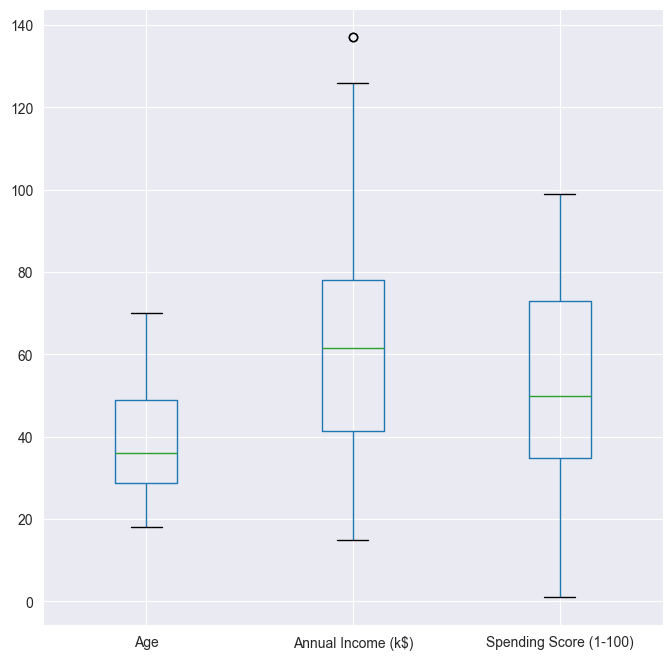

In [160]:
#Haciendo boxplots
df.boxplot(figsize=(8, 8))
plt.show()

<Axes: >

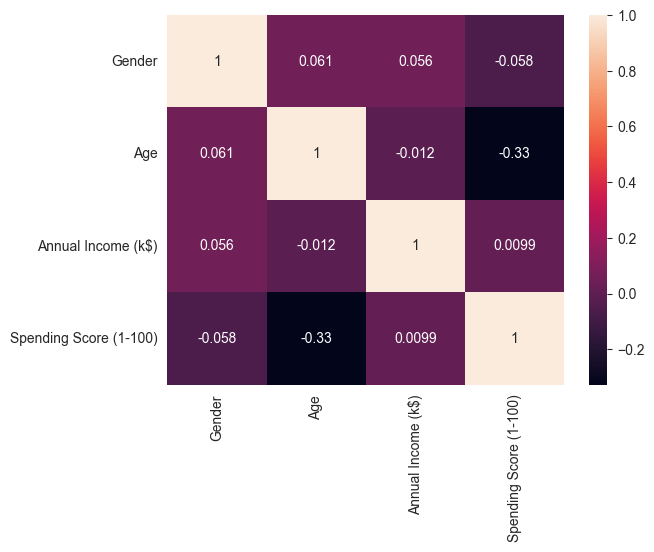

In [161]:
#Codifico la columna Gender en 0 si el cliente es mujer y 1 si es hombre para poder trabajar con ella
df['Gender'] = df['Gender'].map({"Female": 0, "Male": 1})


#Matriz de correlación
sns.heatmap(df.corr(), annot=True)


# Replicando codigo del notebook de vinos (menos la parte inicial que ya hice)

In [162]:
#Configuracion inicial de atributos e importe de librerias
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

In [163]:
#Codigo para limpiar(poner en minusculas y quitar los espacios de) los nombres de las columnas

cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower().replace(' ', '_'))

df.columns = cols_cleaned

# sanity check
df.head()

,gender,age,annual_income_(k$),spending_score_(1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


# Clustering

In [164]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# Guardando tiempos de entrenamiento para cada algoritmo
training_times = []

## Escalando y estandarizando datos

In [165]:
X = StandardScaler().fit_transform(df)
X = PowerTransformer(standardize=False).fit_transform(X)
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

,gender,age,annual_income_(k$),spending_score_(1-100)
0,0.893143,-1.757028,-1.917665,-0.432056
1,0.893143,-1.554328,-1.917665,1.213469
2,-1.087358,-1.655054,-1.872655,-1.683247
3,-1.087358,-1.356711,-1.872655,1.054274
4,-1.087358,-0.621479,-1.827750,-0.393679


## Reducción de la dimensionalidad por medio de UMAP

Antes de la agrupación, el número de características se reduce de 4 a 2. La razón principal es poder «ver» directamente si las agrupaciones identificadas tienen sentido**. Además, (i) las métricas de similitud tienden a funcionar mejor en dimensiones más bajas (las medidas de distancia degeneran para un gran número de características de entrada), y (ii) esta reducción de la dimensionalidad también mitiga la relativamente pobre «relación observaciones-características» de este conjunto de datos.


In [166]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

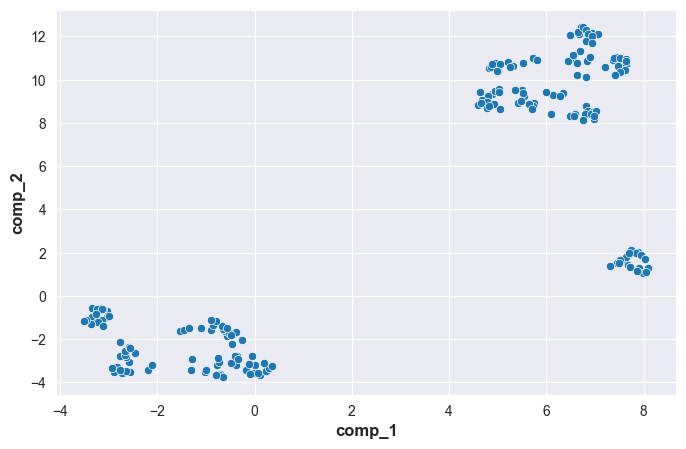

In [167]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

### A primera vista, parece que tenemos tres clusters en nuestro dataset

## Definición de la función de visualización y comprobación de convergencia



In [168]:
# Función para visualizar los clusters identificados

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualización de clusters identificados. Solo se considera un único hiperparámetro.

    Argumentos
    ==========
    df: pandas.DataFrame
        DataFrame de características de entrada.
    labels_all: list | numpy.array
        IDs de clusters identificados.
    hyperparam_name: str | None
        Nombre del hiperparámetro.
    hyperparam_val: float | int | None
        Valor del hiperparámetro.
    noise_exist: bool
        True si el algoritmo modela ruido, False en caso contrario.
        Asume que el ruido se codifica como cluster ID = -1.

    Retorna
    =======
    None
    Imprime una figura.

    """

    # Se omite la comprobación de parámetros de entrada para este notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        # Calcula el porcentaje de outliers (ruido)
        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"  # Usa asteriscos para representar el ruido
            else:
                marker_style = "o"  # Usa círculos para los clusters normales
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Ruido': {outlier_perc}%")
        else:
            plt.title(f"Valores por defecto para todos los hiperparámetros; 'Ruido': {outlier_perc}%")
        plt.legend(title="ID del cluster")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Valores por defecto para todos los hiperparámetros")
        plt.legend(title="ID del cluster")
        plt.show()


def convergence_check(model):
    """Comprueba si el modelo ajustado convergió dentro del número máximo de iteraciones."""
    if model.n_iter_ < model.max_iter:
        print(f"¡El algoritmo convergió exitosamente!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"ADVERTENCIA: ¡El algoritmo no convergió dentro de {model.max_iter} iteraciones!\n")

## Algo 1: K-means

K-means es el algoritmo de clustering más conocido y «básico».
Su hiperparámetro más importante es ***n_clusters***, que es el número de clusters(grupos) que debe buscar el algoritmo.

In [169]:
# hiperparametro a modificar

kmeans_hparam = "n_clusters"

### Identificación del número «óptimo» de clusters
En el contexto de la agrupación mediante K-means, la suma de las distancias al cuadrado de los puntos a sus respectivos centroides se conoce como «**inercia**». En este caso, encontrar un número adecuado de conglomerados significa encontrar el punto de rendimiento decreciente al aumentar el número de centroides. Esto se hace visualmente identificando un posible punto de inflexión en el gráfico de la inercia frente al número de conglomerados.

In [170]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

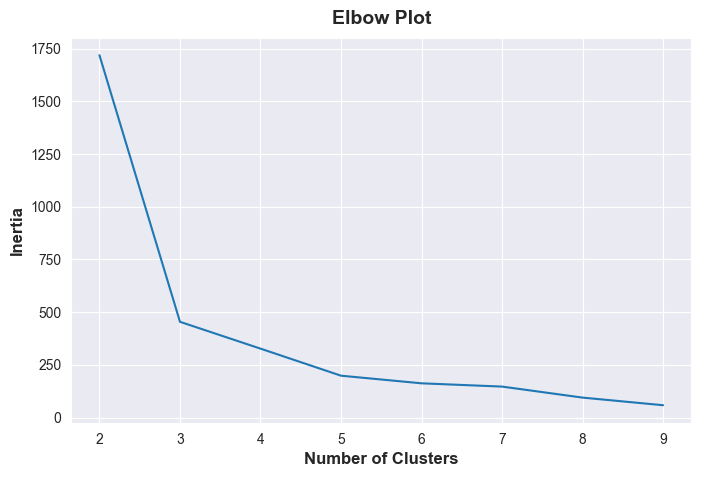

In [171]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Sobresala un codo en 3 clusters. Este es, por tanto, el número de clusters por el que hay que decantarse. Como ya se ha dicho, esto coincide con lo que cabría esperar viendo el grafico de UMAP

### Entrenando un modelo de K-Means con el numero optimo de  *n_clusters*

In [172]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

¡El algoritmo convergió exitosamente!
n_iter: 2, max_iter: 300

CPU times: total: 0 ns
Wall time: 5.02 ms


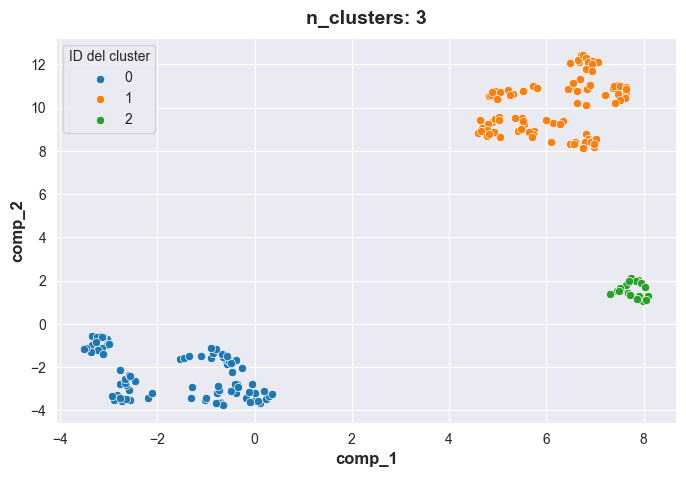

In [173]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

==> Estos resultados parecen muy razonables. Esto no es inesperado, ya que la estructura de los datos es tal que no choca con los supuestos fundamentales de K-means, que los clusters forman **esferas (hiper)no superpuestas** (es decir, «círculos» en 2D) de **más o menos la misma extensión** (y el conjunto de datos no contiene un número «excesivo» de valores atípicos).

### Permitiendo que haya "ruido"
Esto se activa por medio del parametro *cluster_all=False*.

In [174]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

¡El algoritmo convergió exitosamente!
n_iter: 3, max_iter: 300

CPU times: total: 109 ms
Wall time: 3.88 s


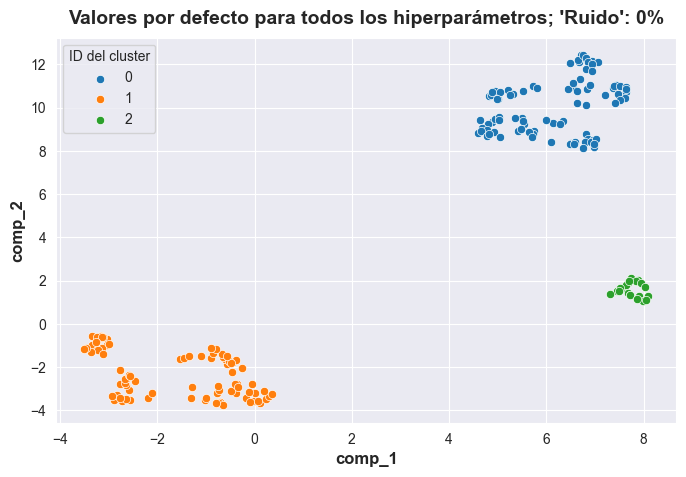

In [175]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Como los clusters están bastante alejados, incluso aceptando que exista ruido, el algoritmo no es capaz de encontrar ningun punto que se considere como tal


## Algo 2: Mean shift
Al igual que K-means, Mean shift es un algoritmo basado en centroides. Sin embargo, a diferencia de K-means, no es necesario especificar por adelantado el número de clusters. Su principal hiperparámetro es ***ancho de banda***, que representa la extensión de las «regiones de búsqueda local». Sin embargo, si no se especifica este parámetro, sklearn proporciona una estimación del mismo. Además, Mean shift también viene con la opción de no asociar necesariamente todos los puntos de datos con un cluster mediante el ajuste *cluster_all* a *False*. Este aspecto del algoritmo también se explora a continuación.

In [176]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Corriendo el algoritmo con los parametros por defecto

In [177]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

¡El algoritmo convergió exitosamente!
n_iter: 3, max_iter: 300

CPU times: total: 78.1 ms
Wall time: 157 ms


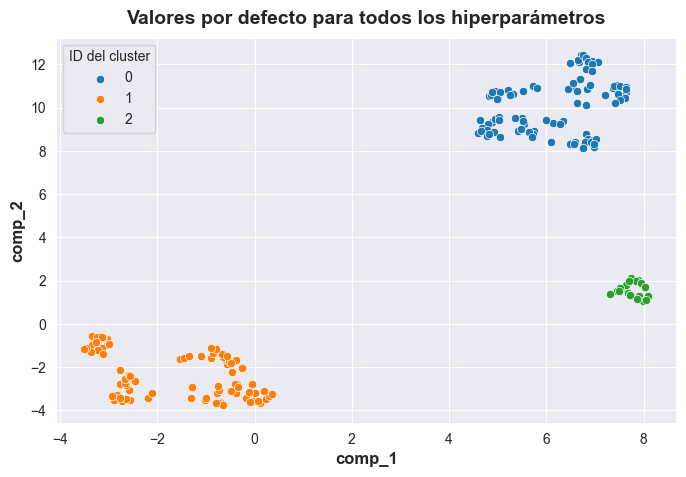

In [178]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

## Algo 3: Mezcla Gaussiana

El modelo de mezcla gaussiano es, como su nombre indica, un algoritmo basado en distribuciones. Su hiperparámetro principal es ***n_componentes***, que corresponde al número de clusters que hay que formar. Como método abreviado, aquí se adopta el número de clusters identificado en la sección K-means.

In [179]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [180]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

¡El algoritmo convergió exitosamente!
n_iter: 2, max_iter: 100

CPU times: total: 219 ms
Wall time: 66.7 ms


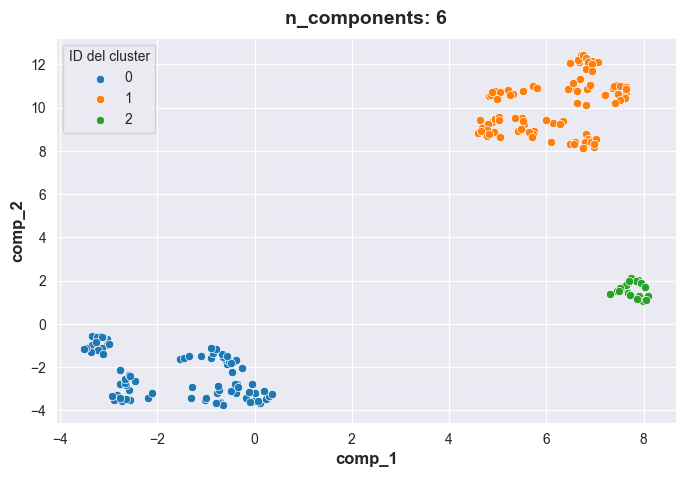

In [181]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=6, noise_exist=False)

### Algo 4: Affinity propagation

La propagación de afinidad no requiere especificar el número de clusters por adelantado. Su principal hiperparámetro es la amortiguación, que es un valor comprendido entre 0,5 (incl.) y 1,0 (excl.).

In [182]:
# hyperparamter to tune

affprop_hparam = "damping"

#### Corriendo el algoritmo con los parametros por defecto

In [183]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

ADVERTENCIA: ¡El algoritmo no convergió dentro de 200 iteraciones!

CPU times: total: 62.5 ms
Wall time: 138 ms


c:\Users\Simon R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


#### Probando distintos valores de damping

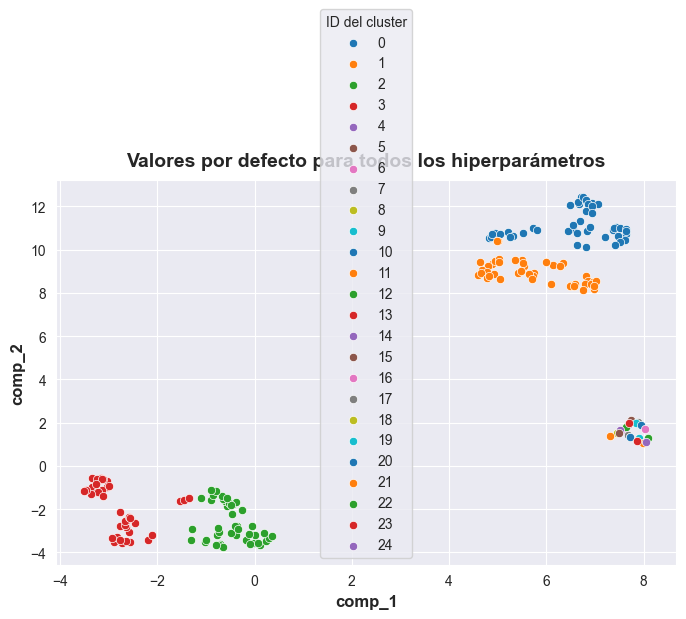

In [184]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

c:\Users\Simon R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


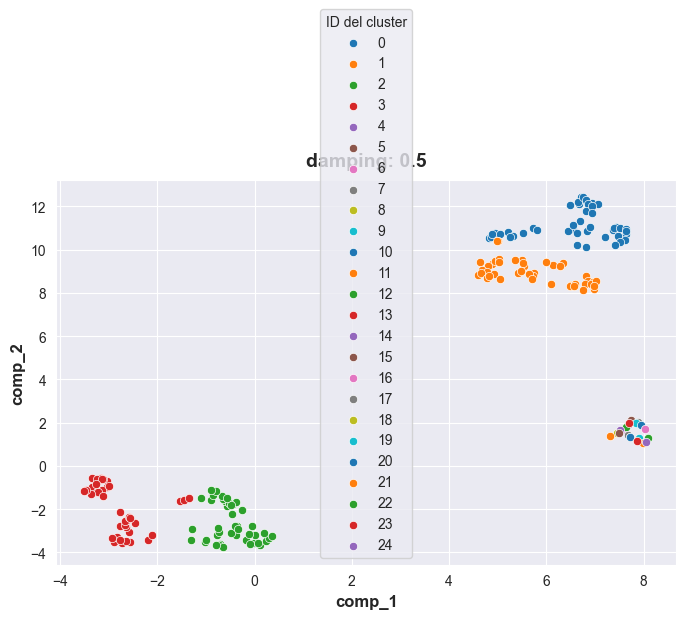

ADVERTENCIA: ¡El algoritmo no convergió dentro de 500 iteraciones!



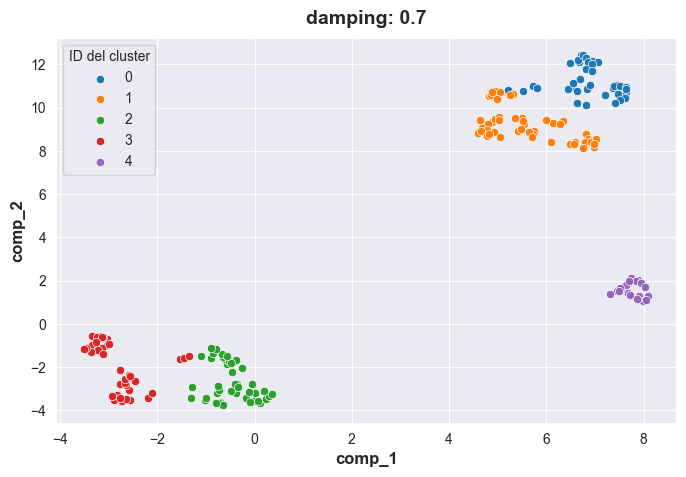

¡El algoritmo convergió exitosamente!
n_iter: 30, max_iter: 500



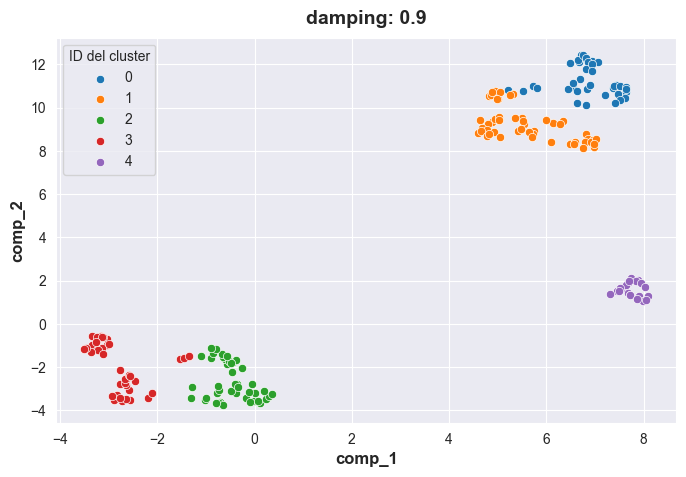

¡El algoritmo convergió exitosamente!
n_iter: 47, max_iter: 500



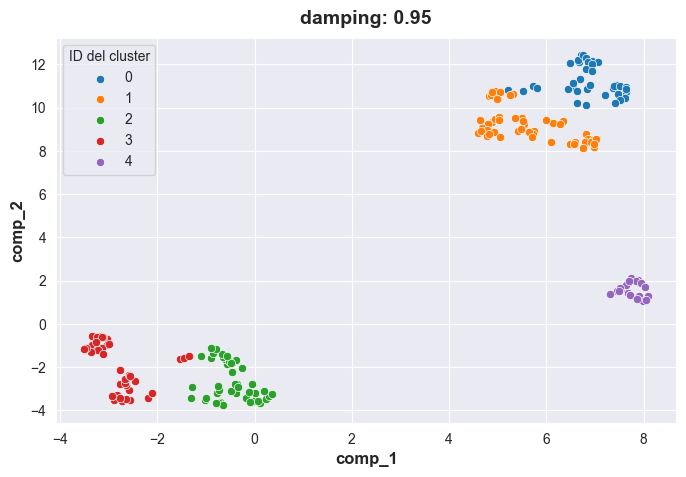

¡El algoritmo convergió exitosamente!
n_iter: 81, max_iter: 500



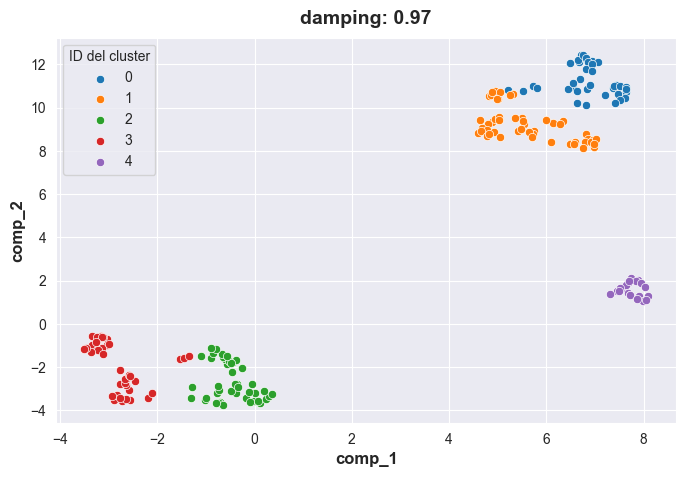

¡El algoritmo convergió exitosamente!
n_iter: 129, max_iter: 500



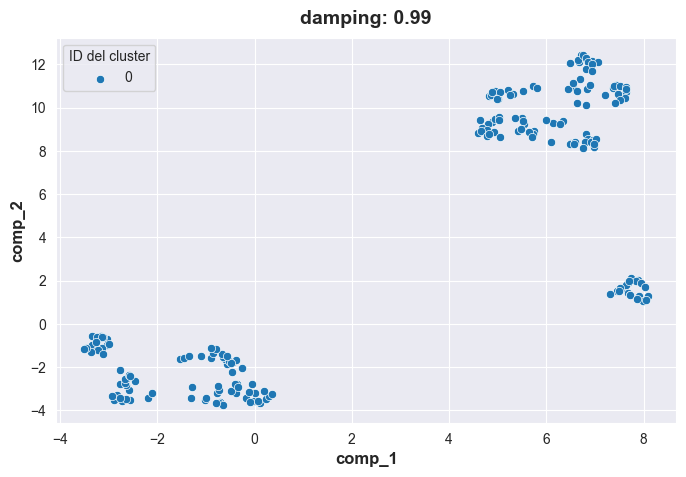

¡El algoritmo convergió exitosamente!
n_iter: 275, max_iter: 500

CPU times: total: 891 ms
Wall time: 3.51 s


In [185]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

### Probando distintos valores de preference

In [186]:
# hyperparamter to tune

affprop_hparam = "preference"

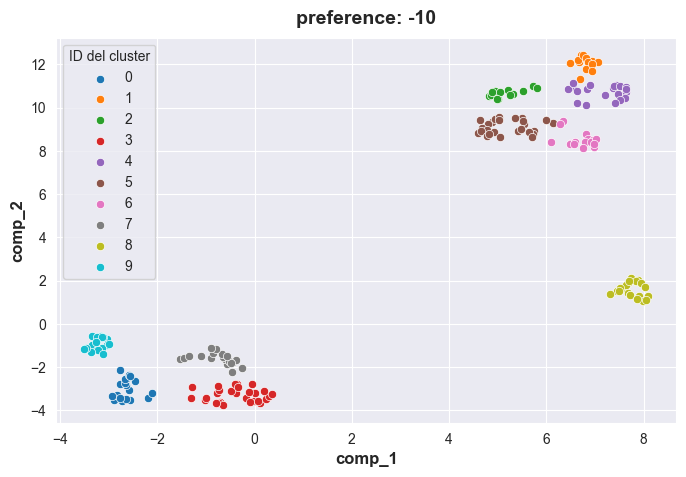

¡El algoritmo convergió exitosamente!
n_iter: 38, max_iter: 500



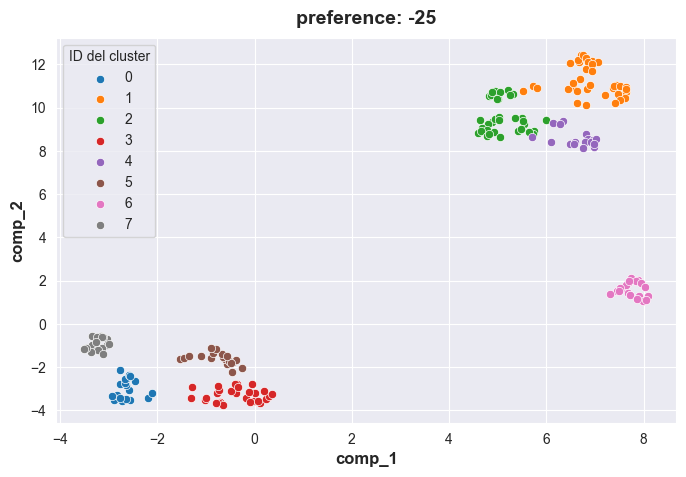

¡El algoritmo convergió exitosamente!
n_iter: 52, max_iter: 500



c:\Users\Simon R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


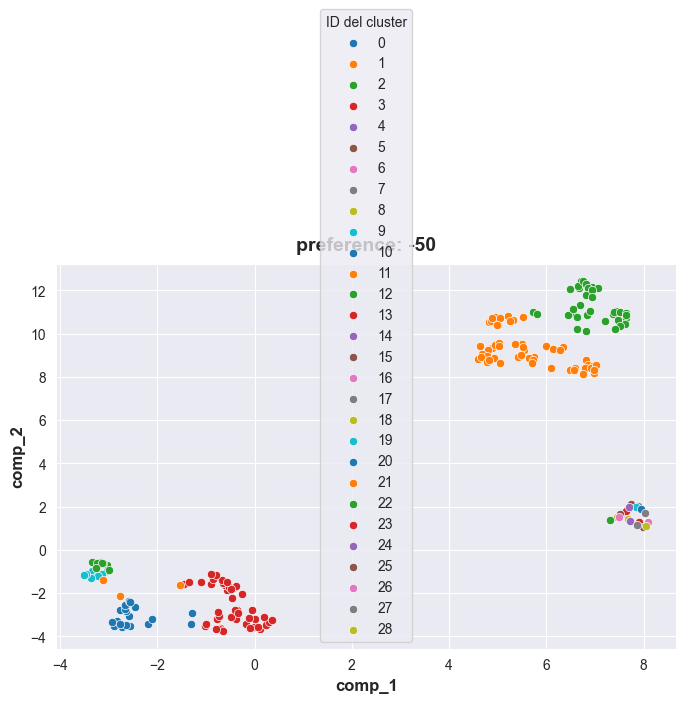

ADVERTENCIA: ¡El algoritmo no convergió dentro de 500 iteraciones!



c:\Users\Simon R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


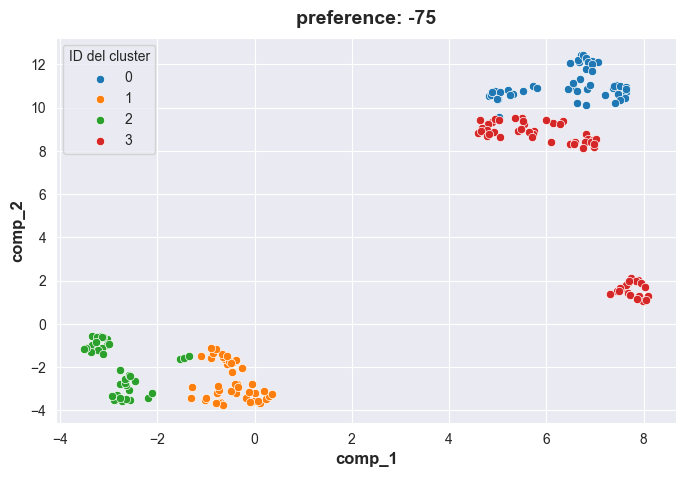

ADVERTENCIA: ¡El algoritmo no convergió dentro de 500 iteraciones!



c:\Users\Simon R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


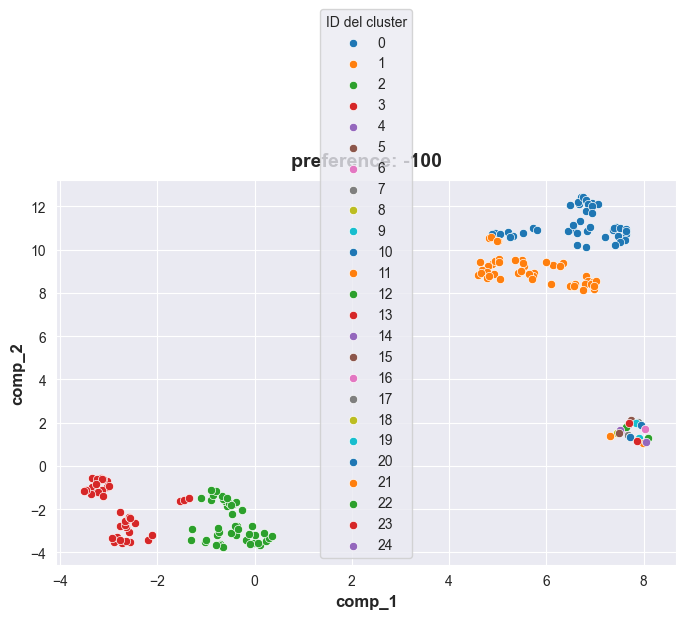

ADVERTENCIA: ¡El algoritmo no convergió dentro de 500 iteraciones!

CPU times: total: 969 ms
Wall time: 5.74 s


In [187]:
%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

### Re-run with optimised preference

In [188]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)

ADVERTENCIA: ¡El algoritmo no convergió dentro de 500 iteraciones!

CPU times: total: 0 ns
Wall time: 421 ms


c:\Users\Simon R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [189]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

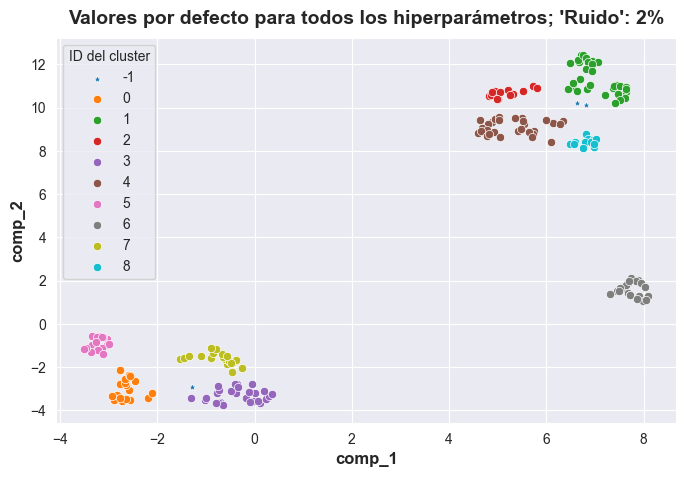

CPU times: total: 78.1 ms
Wall time: 610 ms


In [190]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The result looks quite convincing! It is important to note here that the structure of data is not at odds with what DBSCAN requires in order to work satisfactorily, i.e. that the **clusters are of a roughly similar density**. Approximately 4% off all datapoints were identified as noise here.

### Tuning runs for *eps*

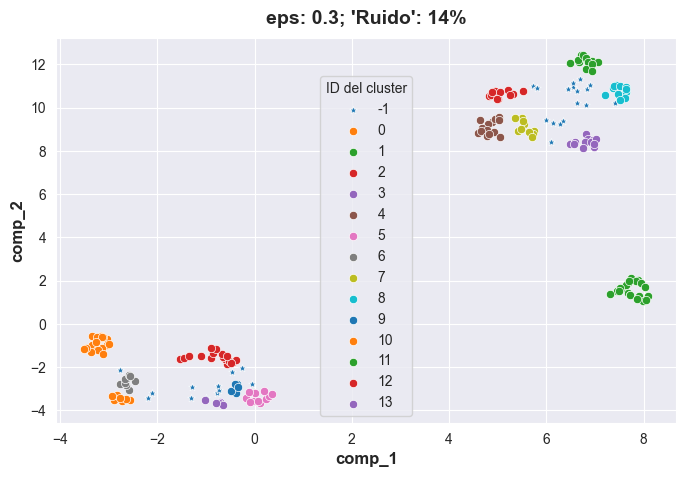

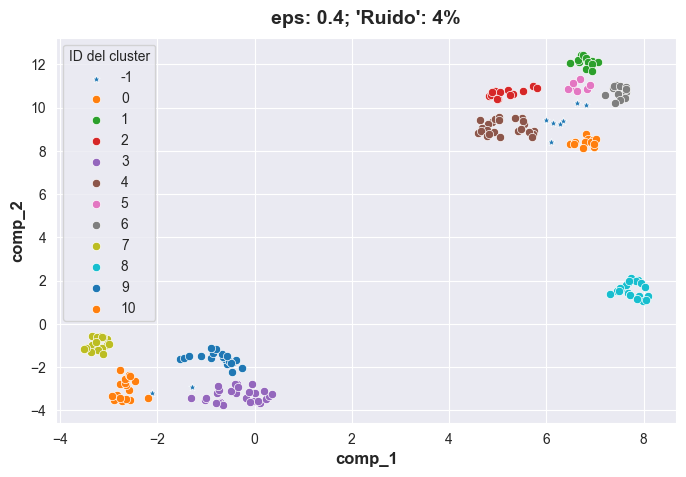

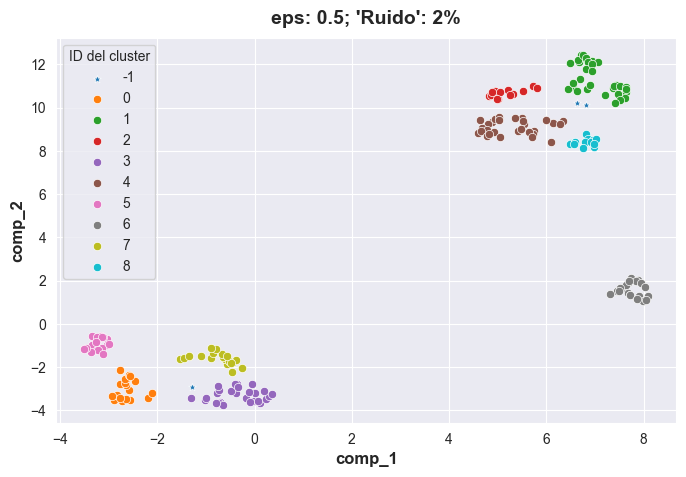

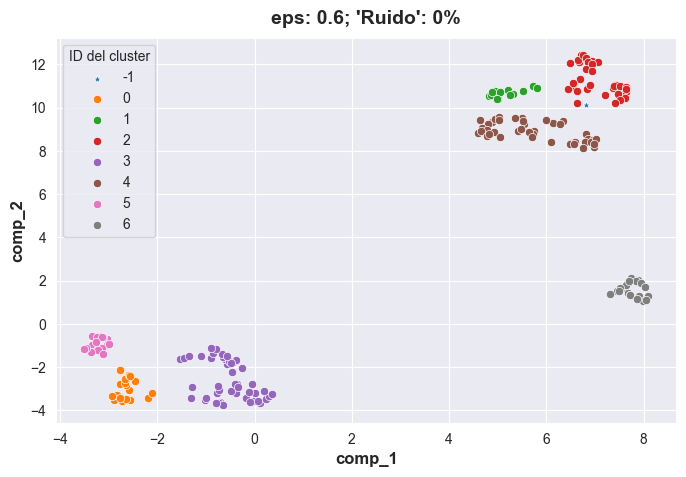

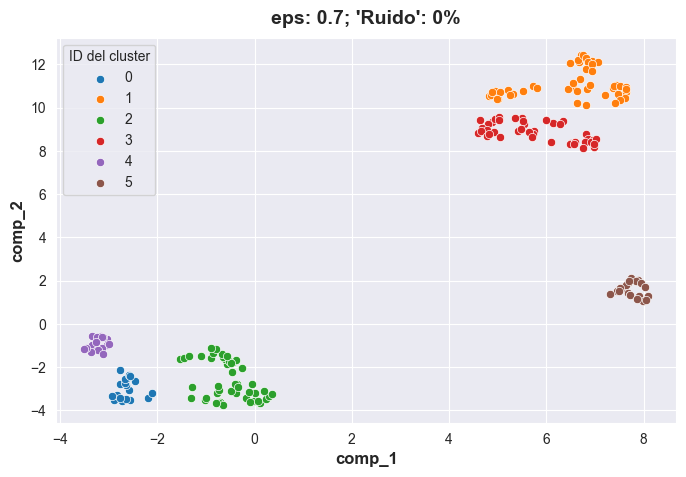

CPU times: total: 406 ms
Wall time: 3.31 s


In [191]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

==> The algorithm shows quite a high sensitivity to ***eps***. A value of around 0.6 seems to work best for this particular dataset.

### Re-run with optimised *eps*

In [192]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: total: 0 ns
Wall time: 81.6 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [193]:
# hyperparamter to tune

optics_hparam = "min_samples"

### Vanilla run (defaults for all hyperparameters)

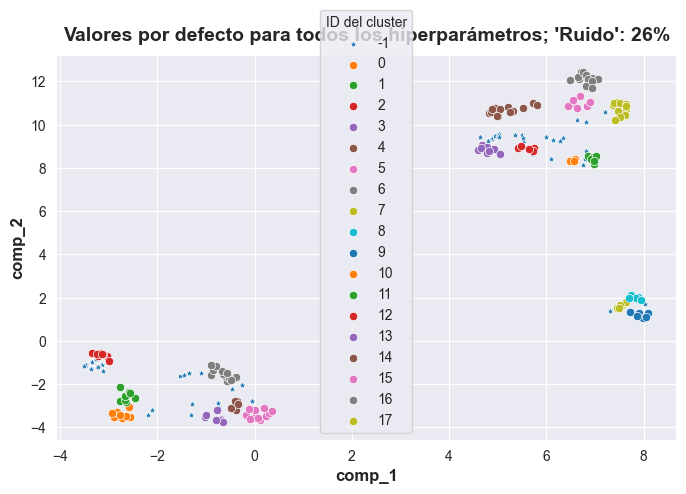

CPU times: total: 359 ms
Wall time: 4.25 s


In [194]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The algorithm identified a considerable number of clusters. Furthermore, a substantial partion of the dataset is labelled as "noise".

### Tuning runs for *min_samples*

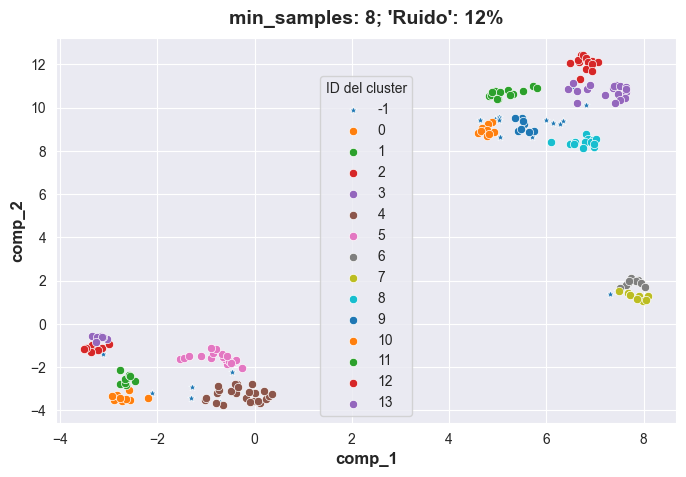

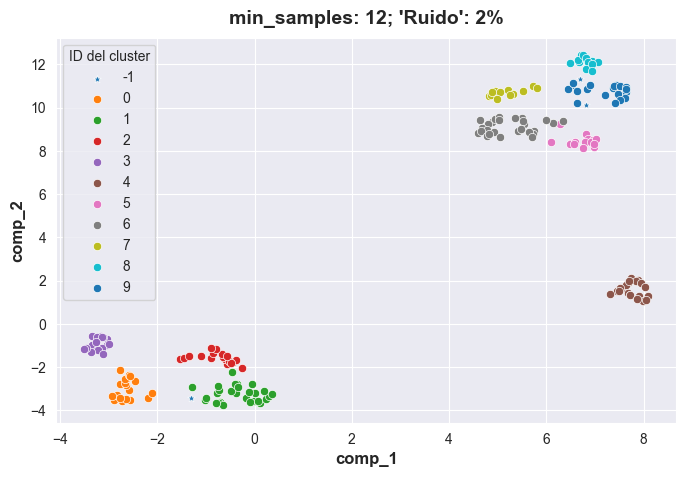

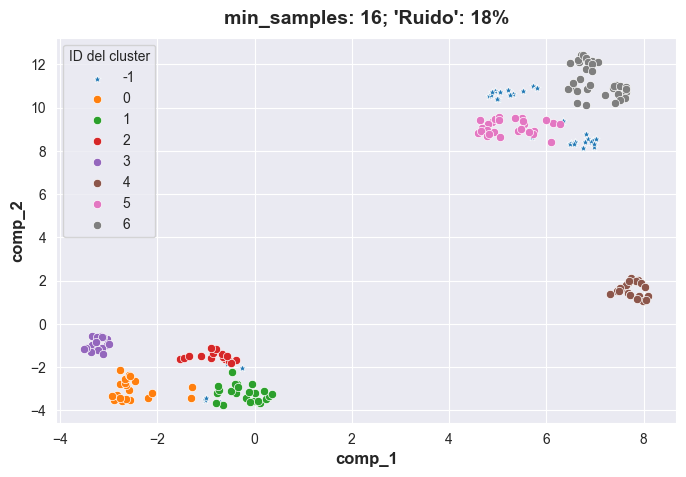

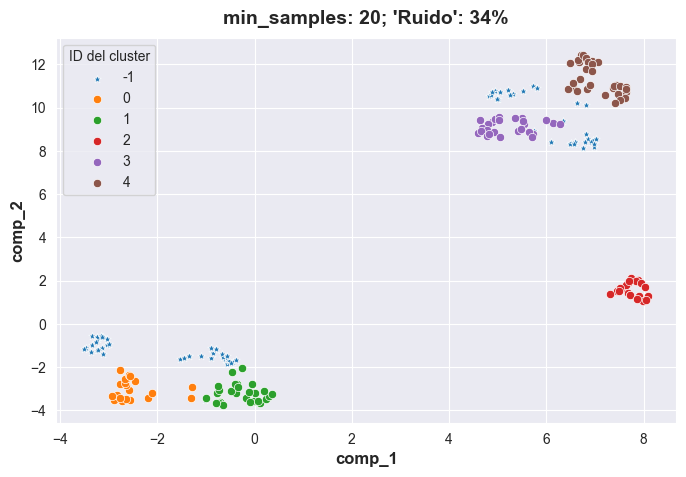

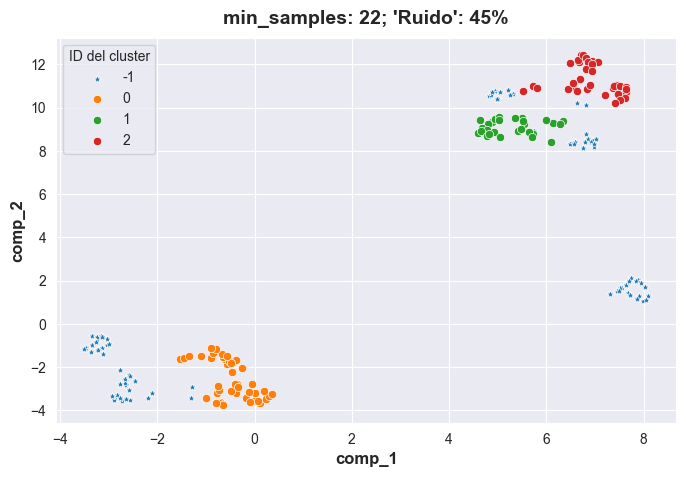

CPU times: total: 1.27 s
Wall time: 20.2 s


In [195]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

==> An approprate value for *min_samples* would be around 20.

### Re-run with optimised *min_samples*

In [196]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: total: 141 ms
Wall time: 3.15 s


# Comparison of training times

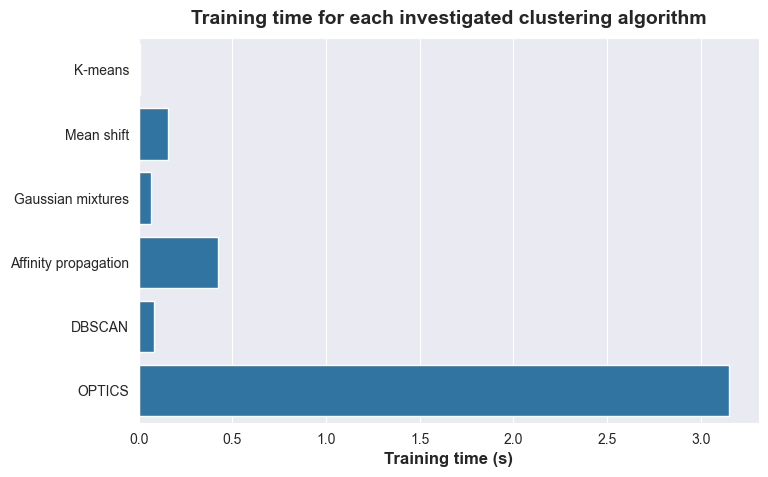

In [197]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

==> The training times across the investigated algorithms **vary considerably**! On the scale of the training times for the Mean shift and OPTICS algorithms, the training times of the other algos practically vanish. Interestingly enough though, when allowing for data points to be considered as "noise" for the Mean shift algo, its training time reduced substantially. For the following, its training time for *cluster_all=False* is taken as its relevant time. Furthermore, OPTICS is excluded so to allow for a comparison of the training times of the remaining algos on a more sensible scale.

In [198]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

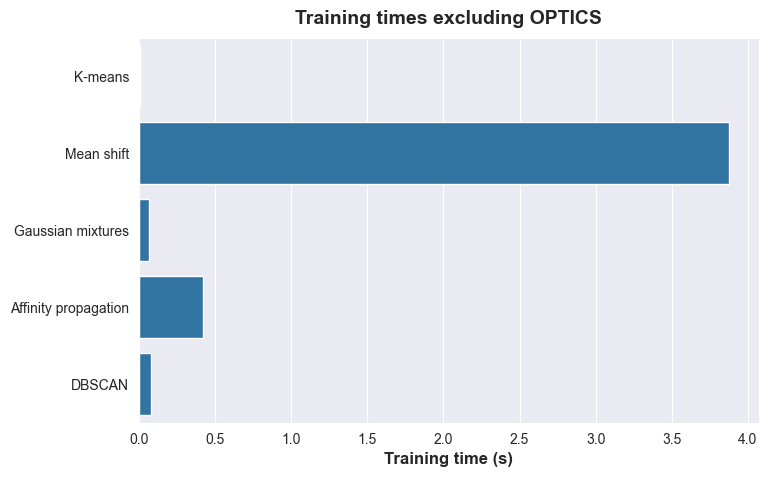

In [199]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()

# Conclusions

As with practically everything else in the machine learning domain, when it comes to clustering there is no "one-size-fits-all" algorithm. Different algorithms tend to be better depending on the structure of the data and in particluar **to what extent this structure is in line with what each algorithm relies on in order to work satisfactorily**. For the relatively simple data structure of the "wine dataset", practically all investigated algorithms performed well (after more or less hyperparameter turning).

Two important caveats regarding the results of this "study":
- Only the **single "most important" hyperparameter** was considered for tuning for each algorithm.
- The **dataset** employed here is **very small**. For datasets of a more real-world size, the relative performance in terms of training times will most likely be different.